Constructing symmetric estimator: 100%|████| 6000/6000 [00:38<00:00, 154.22it/s]


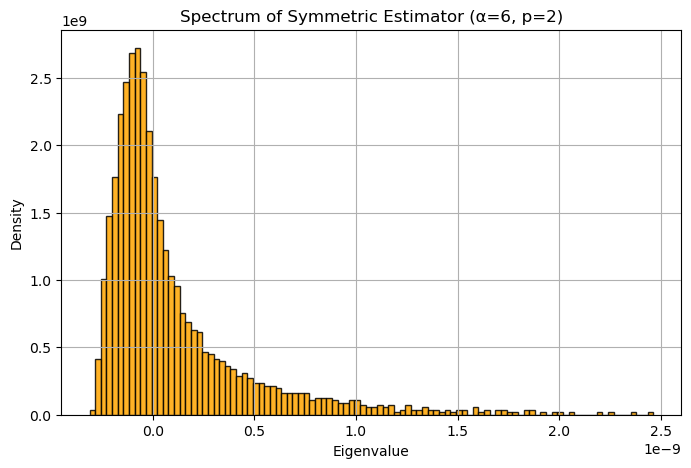

Top-2 eigenvalue energy ratio: 0.0242


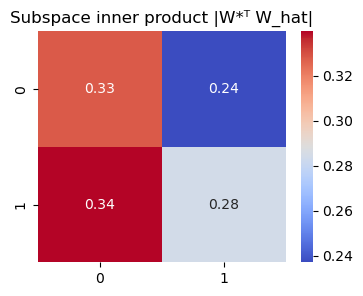

✅ Subspace alignment score: 0.9727
✅ Weak recovery score:      0.0646


In [1]:
import numpy as np
from numpy.linalg import eigh, svd, norm
from scipy.linalg import orth
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import pairwise_distances

# ========================== #
#     参数设置与样本生成      #
# ========================== #
d = 1000       # 特征维度
p = 2          # 子空间维度
alpha = 6      # 采样比 α
n = int(alpha * d)

np.random.seed(0)

# 真子空间 W_star（正交基）
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# 输入样本 X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d)

# 隐变量 Z = X @ W_star
Z = X @ W_star

# Zero-mean 化 Z（关键步骤）
Z_centered = Z - Z.mean(axis=0, keepdims=True)

# link function: g(z1, z2) = z1 * z2
def link_function(z):
    return (z[:, 0] * z[:, 1]).reshape(-1, 1)

y = link_function(Z)

# ========================== #
#     σ计算：基于 y 的距离中位数 #
# ========================== #
pairwise_dists = pairwise_distances(y)
sigma = np.median(pairwise_dists)

# ========================== #
#     核估计条件期望 E[zzᵀ|y] #
# ========================== #
gamma = 1.0 / (2 * sigma ** 2)
K = rbf_kernel(y, y, gamma=gamma)
K /= K.sum(axis=1, keepdims=True)

E_matrices = np.zeros((n, p, p))
zzts = np.einsum('ij,ik->ijk', Z_centered, Z_centered)  # z_j z_jᵀ

for i in range(n):
    weighted_sum = np.tensordot(K[i], zzts, axes=1)
    E_matrices[i] = weighted_sum

# 减去整体均值，构造 unbiased 版本（optional）
E_global = np.mean(E_matrices, axis=0)
E_matrices -= E_global[np.newaxis, :, :]

# 正则化，防止奇异性
E_matrices += 1e-4 * np.eye(p)[np.newaxis, :, :]

# ========================== #
#     构造对称谱矩阵 T         #
# ========================== #
T_matrix = np.zeros((d * p, d * p))
for i in tqdm(range(n), desc="Constructing symmetric estimator"):
    x = X[i]
    T_y = E_matrices[i]
    for a in range(p):
        for b in range(p):
            T_matrix[a*d:(a+1)*d, b*d:(b+1)*d] += T_y[a, b] * np.outer(x, x)
T_matrix /= (n * d)

# ========================== #
#     谱分解与子空间提取       #
# ========================== #
eigvals, eigvecs = eigh(T_matrix)
top_components = eigvecs[:, -p:]

# 拼接分块并取正交子空间基
W_blocks = [top_components[i*d:(i+1)*d] for i in range(p)]
W_hat_raw = np.mean(W_blocks, axis=0)
W_hat = orth(W_hat_raw)

# ========================== #
#     Weak Recovery & 对齐度  #
# ========================== #
Q = W_star @ W_star.T
P_hat = W_hat @ W_hat.T
M_hat = P_hat @ Q @ P_hat
weak_recovery_score = norm(M_hat, ord='fro')**2 / np.trace(Q)

U_align, _, Vt_align = svd(W_star.T @ W_hat)
alignment_score = np.mean(np.diag(U_align @ Vt_align) ** 2)

# ========================== #
#         可视化输出          #
# ========================== #
plt.figure(figsize=(8, 5))
plt.hist(eigvals, bins=100, density=True, color='orange', edgecolor='black', alpha=0.85)
plt.title(f"Spectrum of Symmetric Estimator (α={alpha}, p={p})")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# 特征值能量占比
total_energy = np.sum(eigvals)
top_energy = np.sum(eigvals[-p:])
print(f"Top-{p} eigenvalue energy ratio: {top_energy / total_energy:.4f}")

# 子空间方向热力图
plt.figure(figsize=(4, 3))
sns.heatmap(np.abs(W_star.T @ W_hat), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Subspace inner product |W*ᵀ W_hat|")
plt.show()

# 打印对齐与恢复指标
print(f"✅ Subspace alignment score: {alignment_score:.4f}")
print(f"✅ Weak recovery score:      {weak_recovery_score:.4f}")


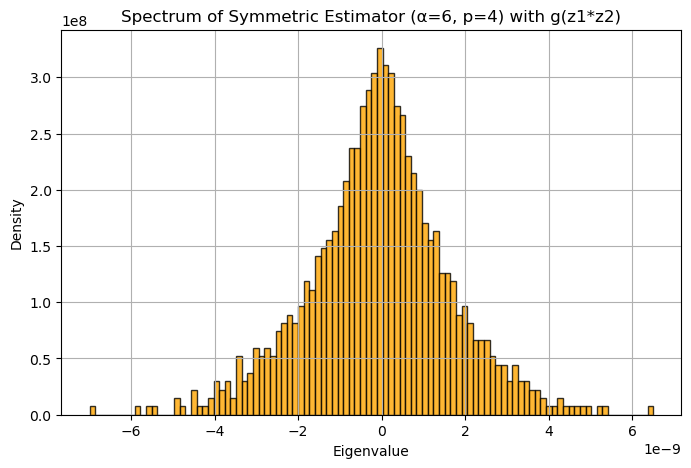

In [1]:
import numpy as np
from numpy.linalg import eigh, norm
import matplotlib.pyplot as plt

# 缩小规模参数
d = 1000             # 特征维度（保持固定）
p = 4                # 子空间维度
alpha = 6            # 可调节：采样比 α
n = int(d * alpha)   # 根据 alpha 自动计算样本数量
alpha_c = p / 2      # 临界采样比 α_c = p / 2
np.random.seed(42)

# Step 1: 信号子空间 W_star
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# Step 2: 输入样本 X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d) 

# Step 3: 隐变量 Z = X @ W_star
Z = X @ W_star

# Step 4: link function: g(z1, z2) = z1 * z2
def link_function(z):
    return (z[:, 0] * z[:, 1])  # shape: (n,)

y = link_function(Z)  # shape: (n,)

# Step 5: T(y_i) = G(G + I)^-1 where G = y_i * I_p
def compute_T_y_batch(y_batch):
    return np.array([
        p * (yi * np.eye(p)) @ np.linalg.inv(yi * np.eye(p) + np.eye(p)) for yi in y_batch
    ])

# Step 6: 批量构造对称谱矩阵
T_matrix = np.zeros((d * p, d * p))

batch_size = 500  # 分批处理避免太慢
for i in range(0, n, batch_size):
    X_batch = X[i:i+batch_size]                  # shape: (B, d)
    y_batch = y[i:i+batch_size]                  # shape: (B,)
    T_batch = compute_T_y_batch(y_batch)         # shape: (B, p, p)

    for j in range(len(X_batch)):
        xxT = np.outer(X_batch[j], X_batch[j])   # ∈ ℝ^{d×d}
        T_y = T_batch[j]                          # ∈ ℝ^{p×p}
        T_matrix += np.kron(xxT, T_y)

T_matrix /= (n * d)  # 归一化

# Step 7: 求谱
eigvals, _ = eigh(T_matrix)

# 可选可视化
plt.figure(figsize=(8, 5))
plt.hist(eigvals, bins=100, density=True, color='orange', edgecolor='black', alpha=0.8)
plt.title(f"Spectrum of Symmetric Estimator (α={alpha}, p={p}) with g(z1*z2)")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.show()


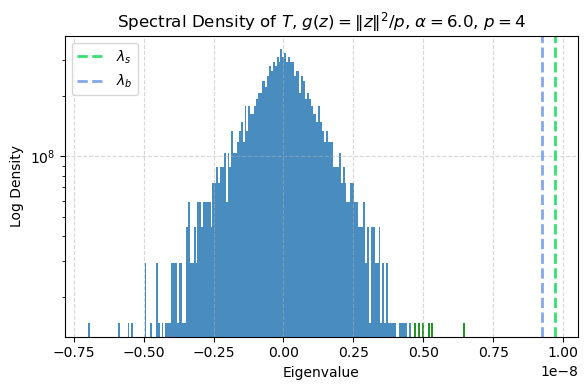

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 假设你已有这些变量
# eigvals：特征值数组（升序）
# alpha, p：采样比与信号维度
lambda_s = 9.70161885e-09
lambda_b = 9.23452852e-9
alpha = 6.0
p = 4

# 保存路径和文件名
save_path = r"./figures"  # 你可以改为你自己的路径
filename_base = f"spectrum_alpha{alpha}_p{p}"

# 如果文件夹不存在则创建
os.makedirs(save_path, exist_ok=True)

# 设置颜色
bulk_color = '#2878B5'     # 蓝紫色
signal_color = 'green'     # 信号柱子绿色

# Step 1: 计算 histogram 数据
hist, bin_edges = np.histogram(eigvals, bins=200, density=True)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 2: 找到最大 24 个特征值所在的 bin 索引
eigvals_sorted = np.sort(eigvals)
signal_eigs = eigvals_sorted[-24:]  # 可改为 -4 表示4个
signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

# Step 3: 绘图
plt.figure(figsize=(6, 4))

for i in range(len(hist)):
    color = signal_color if i in signal_bins else bulk_color
    plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.85)

# Step 4: 添加竖线
plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=2, label=r'$\lambda_s$')
plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=2, label=r'$\lambda_b$')

# Step 5: 其他设置
plt.yscale('log')
plt.title(r"Spectral Density of $T$, $g(z) = \|z\|^2/p$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
plt.xlabel("Eigenvalue")
plt.ylabel("Log Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# Step 6: 保存图像为 PDF 和 PNG（论文标准）
plt.savefig(os.path.join(save_path, filename_base + ".pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(save_path, filename_base + ".png"), dpi=300, bbox_inches='tight')

# Step 7: 显示图像
plt.show()


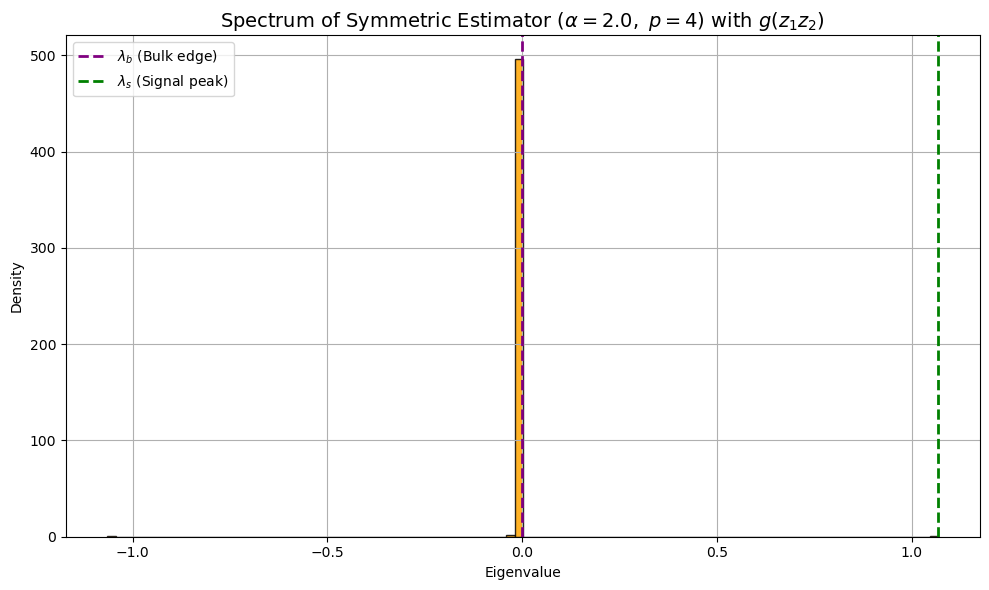

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# 参数设置
n = 1000      # 样本数
d = 500         # 变量维度
p = 4           # 有效子空间维度（即 z ∈ ℝ^p）
alpha = n / d   # 采样比
np.random.seed(42)

# 生成信号子空间 w ∈ ℝ^{d×p}, 保证正交
W = np.linalg.qr(np.random.randn(d, p))[0]  # 正交列向量

# 生成低维表示 z ∈ ℝ^{n×p}
Z = np.random.randn(n, p)

# 高维输入 x_i = W z_i + noise
X = Z @ W.T + 0.01 * np.random.randn(n, d)  # 噪声项控制不变

# 构造响应 y_i = z1 * z2
y = Z[:, 0] * Z[:, 1]  # link function g(z1, z2) = z1 * z2

# 计算 T(y_i) = y_i * zz^T（对称谱估计器核心）
T_matrices = np.zeros((d, d))
for i in range(n):
    x_i = X[i, :].reshape(-1, 1)
    T_matrices += y[i] * (x_i @ x_i.T)

# 标准化 T
T_matrix = T_matrices / n

# 计算特征值
eigvals = np.linalg.eigvalsh(T_matrix)
eigvals_sorted = np.sort(eigvals)

# 取谱体边界 λ_b 和主谱值 λ_s
λ_b = eigvals_sorted[-p-1]  # 谱体右端边界
λ_s = eigvals_sorted[-1]    # 最大特征值（主成分）

# 可视化
plt.figure(figsize=(10, 6))
plt.hist(eigvals_sorted, bins=100, color='orange', alpha=0.85, edgecolor='black')
plt.axvline(x=λ_b, color='purple', linestyle='--', linewidth=2, label=r'$\lambda_b$ (Bulk edge)')
plt.axvline(x=λ_s, color='green', linestyle='--', linewidth=2, label=r'$\lambda_s$ (Signal peak)')
plt.title(r"Spectrum of Symmetric Estimator $(\alpha=%.1f,\ p=%d)$ with $g(z_1 z_2)$" % (alpha, p), fontsize=14)
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
